In [1]:
# import dependencies
from splinter import Browser
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import praw
from config import username,password,clientid,secret
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import re

In [2]:
# setup for splinter
executable_path={'executable_path':'/usr/local/bin/chromedriver'}
browser = Browser('chrome', incognito=True)

In [3]:
# search for all url related to coronavirus megathread in the melbourne subreddit
url='http://www.reddit.com/r/melbourne/'
browser.visit(url)
sleep(1)
browser.find_by_id('header-search-bar').fill('coronavirus megathread\n')
sleep(1)
browser.find_by_text('Show results from').first.click()

In [4]:
# scroll to bottom of page to load all urls
cont=True
while cont=True:
    browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    html=browser.html
    soup=BeautifulSoup(html,'lxml')
    content = soup.find_all('a')
    for r in content:
        if r["href"].find("_megathread")>=0:
            cont=False

In [5]:
html=browser.html
soup=BeautifulSoup(html,'lxml')
result=soup.find_all('a')

In [6]:
megathread_links=[]
for r in result:
    if ('megathread' in r.text.lower()) and ('/r/melbourne/comments/' in r['href']):
        url='https://www.reddit.com'+r['href']
        megathread_links.append(url)
        print(url)

https://www.reddit.com/r/melbourne/comments/j1id4t/daily_coronavirus_megathread_29_september_2020/
https://www.reddit.com/r/melbourne/comments/j0woow/daily_coronavirus_megathread_28_september_2020/
https://www.reddit.com/r/melbourne/comments/j0bo9g/daily_coronavirus_megathread_26_september_2020/
https://www.reddit.com/r/melbourne/comments/iykvsv/coronavirus_megathread_part_57_do_you_suffer_from/
https://www.reddit.com/r/melbourne/comments/ivg7qh/coronavirus_megathread_part_56_lock_down_girl/
https://www.reddit.com/r/melbourne/comments/is907p/coronavirus_megathread_part_55_just_another/
https://www.reddit.com/r/melbourne/comments/ir017w/coronavirus_megathread_part_54_patch_notes/
https://www.reddit.com/r/melbourne/comments/invw9e/coronavirus_megathread_part_53_lockdown_funk/
https://www.reddit.com/r/melbourne/comments/inbire/coronavirus_megathread_part_53_supercomputer_says/
https://www.reddit.com/r/melbourne/comments/im5ioj/coronavirus_megathread_part_52_weve_vaccine/
https://www.reddi

In [7]:
browser.quit()

In [8]:
# use praw to extract comments from reddit
reddit = praw.Reddit(user_agent="Comment Extraction (by /u/username)",
                     client_id=clientid, client_secret=secret,
                     username=username, password=password)

In [9]:
# from https://praw.readthedocs.io/en/latest/tutorials/comments.html
def scrapereddit(url):
    submission = reddit.submission(url=url)
    subdate=datetime.fromtimestamp(submission.created_utc).strftime('%Y-%m-%d')
    submissionList = []
    timeStamp = []
    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        submissionList.append(comment.body)
        timeStamp.append(datetime.fromtimestamp(comment.created_utc).strftime('%Y-%m-%d'))
    return submissionList,timeStamp

In [10]:
# from https://gist.github.com/acrymble/1065622
def fwordcount(submissionList):
    fword=[]
    for val in submissionList: 
        val = str(val)   
        val=re.compile(r'\W+', re.UNICODE).split(val)
        val=[v.lower() for v in val]
        count=0
        for v in val:
            if "fuck" in v:
                count+=1
        fword.append(count)
    return fword

In [14]:
# count number of f words
date=[]
count=[]
for url in megathread_links:
    submissionList,timeStamp=scrapereddit(url)
    fcount=fwordcount(submissionList)
    df=pd.DataFrame({
        "date":timeStamp,
        "fword":fcount})
    fwordDate=df.groupby("date")["fword"].sum()
    for i in range(len(fwordDate)):
        print(fwordDate.index[i])
        date.append(fwordDate.index[i])
        print(fwordDate[i])
        count.append(fwordDate[i])

2020-09-28
113
2020-09-27
247
2020-09-28
9
2020-09-24
136
2020-09-25
216
2020-09-26
17
2020-09-27
1
2020-09-28
0
2020-09-19
119
2020-09-20
137
2020-09-21
113
2020-09-22
143
2020-09-23
114
2020-09-24
11
2020-09-25
0
2020-09-26
0
2020-09-14
113
2020-09-15
218
2020-09-16
143
2020-09-17
125
2020-09-18
206
2020-09-19
10
2020-09-20
0
2020-09-21
0
2020-09-22
0
2020-09-12
137
2020-09-13
153
2020-09-14
23
2020-09-15
0
2020-09-18
0
2020-09-20
0
2020-09-07
314
2020-09-08
220
2020-09-09
231
2020-09-10
229
2020-09-11
174
2020-09-12
13
2020-09-13
0
2020-09-14
1
2020-09-17
1
2020-09-18
0
2020-09-19
0
2020-09-20
0
2020-09-06
617
2020-09-07
47
2020-09-08
0
2020-09-09
0
2020-09-10
0
2020-09-04
159
2020-09-05
279
2020-09-06
62
2020-09-07
0
2020-09-03
261
2020-09-04
37
2020-09-05
0
2020-09-06
0
2020-09-07
0
2020-09-14
0
2020-09-19
0
2020-09-26
0
2020-09-01
97
2020-09-02
157
2020-09-03
76
2020-09-04
0
2020-09-07
0
2020-08-27
106
2020-08-28
78
2020-08-29
124
2020-08-30
188
2020-08-31
204
2020-09-01
21
2020-

In [11]:
# either convert to a dataframe, or save in a dataframe
#fWord_df=pd.DataFrame(
#{
#    "Date":date,
#    "Count":count
#})
#fword_df.to_csv("data/fWordCount.csv",index=False)
fWord_df=pd.read_csv("data/fWordCount.csv")
fWord_df

,Date,Count
0,2020-09-28,113
1,2020-09-27,247
2,2020-09-28,9
3,2020-09-24,136
4,2020-09-25,216
...,...,...
429,2020-03-12,2
430,2020-03-13,0
431,2020-03-14,0
432,2020-03-15,1


In [12]:
# clean dataframe
fWordDate_df=pd.DataFrame(fWord_df.groupby("Date")["Count"].sum())
fWordDate_df=fWordDate_df.reset_index()
fWordDate_df=fWordDate_df.dropna()
fWordDate_df

,Date,Count
0,2020-03-03,14
1,2020-03-04,4
2,2020-03-05,4
3,2020-03-06,2
4,2020-03-07,6
...,...,...
205,2020-09-24,147
206,2020-09-25,216
207,2020-09-26,17
208,2020-09-27,248


In [13]:
fWordDate_df["Date"]=pd.to_datetime(fWordDate_df["Date"], infer_datetime_format=True)  

In [14]:
# get covid cases from covidlive
cases=pd.read_html("https://covidlive.com.au/report/daily-cases/vic")
cases_df=cases[1]
cases_df

,DATE,CASES,VAR,NET
0,29 Sep,20158,NaN,9
1,28 Sep,20149,NaN,4
2,27 Sep,20145,NaN,16
3,26 Sep,20129,NaN,11
4,25 Sep,20118,NaN,13
...,...,...,...,...
244,29 Jan,3,NaN,2
245,28 Jan,1,NaN,0
246,27 Jan,1,NaN,0
247,26 Jan,1,NaN,0


In [15]:
cases_df=cases_df[["DATE","NET"]].copy()
cases_df["date"]=cases_df["DATE"]+" 2020"
cases_df["date"]=pd.to_datetime(cases_df["date"], infer_datetime_format=True)  
cases_df

,DATE,NET,date
0,29 Sep,9,2020-09-29
1,28 Sep,4,2020-09-28
2,27 Sep,16,2020-09-27
3,26 Sep,11,2020-09-26
4,25 Sep,13,2020-09-25
...,...,...,...
244,29 Jan,2,2020-01-29
245,28 Jan,0,2020-01-28
246,27 Jan,0,2020-01-27
247,26 Jan,0,2020-01-26


In [17]:
# merge case and fword count
fWordDate_df=pd.merge(fWordDate_df,cases_df,left_on="Date",right_on="date")
fWordDate_df=fWordDate_df[["Date","Count","NET"]]
# convert data type
fWordDate_df["Cases"]=fWordDate_df["NET"].astype("int")
fWordDate_df=fWordDate_df[["Date","Count","Cases"]]
fWordDate_df.head()

,Date,Count,Cases
0,2020-03-03,14,0
1,2020-03-04,4,1
2,2020-03-05,4,0
3,2020-03-06,2,0
4,2020-03-07,6,1


In [18]:
# get 3 day rolling average
for i in range(0,fWordDate_df.shape[0]-2):
    fWordDate_df.loc[fWordDate_df.index[i+2],'count_3day'] = np.round(((fWordDate_df.iloc[i,1]+ fWordDate_df.iloc[i+1,1] +fWordDate_df.iloc[i+2,1])/3),1)
    fWordDate_df.loc[fWordDate_df.index[i+2],'case_3day'] = np.round(((fWordDate_df.iloc[i,2]+ fWordDate_df.iloc[i+1,2] +fWordDate_df.iloc[i+2,2])/3),1)
fWordDate_df.to_csv("data/caseVfs.csv",index=False)

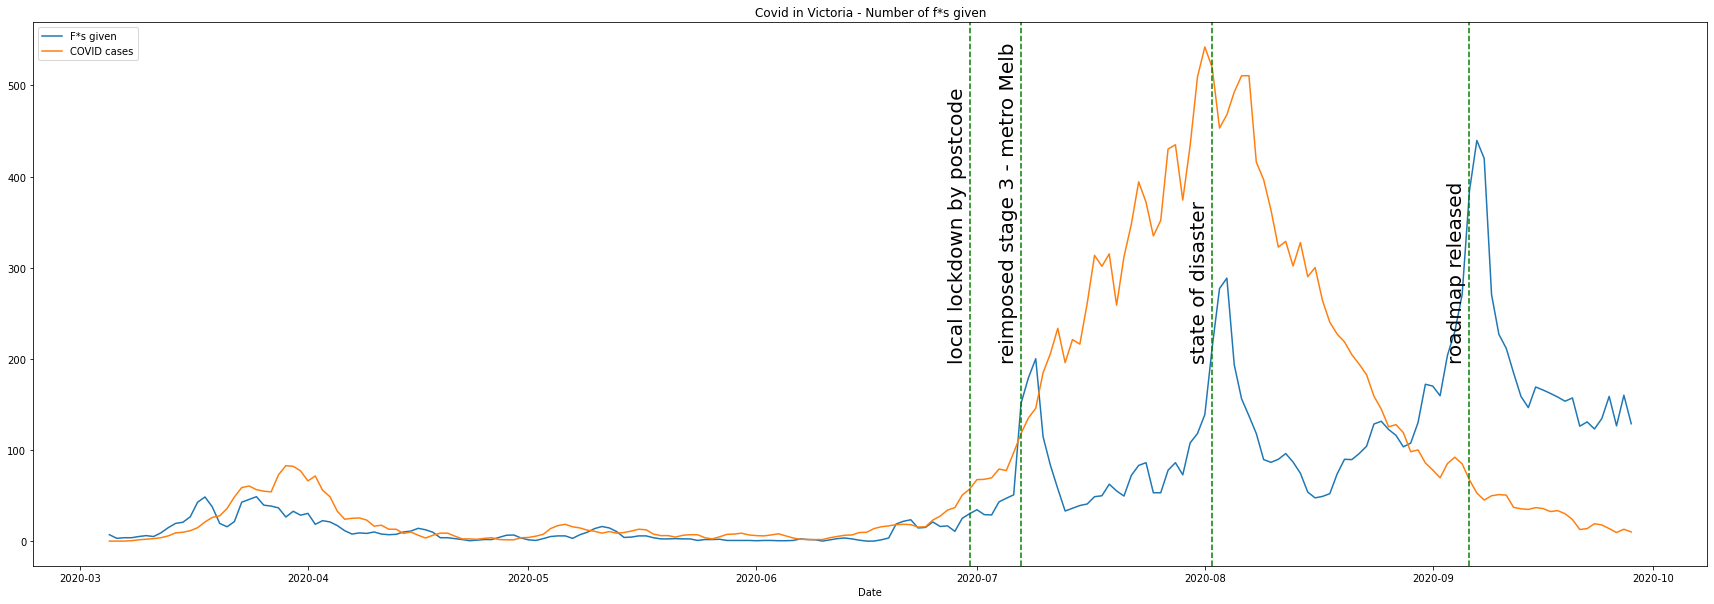

In [19]:
# plot and save fig
plt.figure(figsize=(30,10))
plt.plot(fWordDate_df["Date"],fWordDate_df["count_3day"],label="F*s given")
plt.plot(fWordDate_df["Date"],fWordDate_df["case_3day"],label="COVID cases")
plt.xlabel("Date")
plt.title("Covid in Victoria - Number of f*s given")
plt.legend(loc="upper left")
plt.rcParams.update({'font.size': 30})
plt.axvline(x=datetime.strptime("30 June, 2020", "%d %B, %Y"),color="green",linestyle="--")
plt.text(datetime.strptime("27 June, 2020", "%d %B, %Y"),200,"local lockdown by postcode",rotation=90,size=20)
plt.axvline(x=datetime.strptime("7 July, 2020", "%d %B, %Y"),color="green",linestyle="--")
plt.text(datetime.strptime("4 July, 2020", "%d %B, %Y"),200,"reimposed stage 3 - metro Melb",rotation=90,size=20)
plt.axvline(x=datetime.strptime("2 August, 2020", "%d %B, %Y"),color="green",linestyle="--")
plt.text(datetime.strptime("30 July, 2020", "%d %B, %Y"),200,"state of disaster",rotation=90,size=20)
plt.axvline(x=datetime.strptime("6 September, 2020", "%d %B, %Y"),color="green",linestyle="--")
plt.text(datetime.strptime("3 September, 2020", "%d %B, %Y"),200,"roadmap released",rotation=90,size=20)
plt.savefig("fig/COVID_fs.png")
plt.show()